In [2]:
import os
import tarfile

import numpy as np
import pandas as pd
from scipy.stats import randint
from six.moves import urllib
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedShuffleSplit,
    train_test_split,
)
from sklearn.tree import DecisionTreeRegressor

In [3]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


fetch_housing_data()
housing = load_housing_data()

In [4]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [5]:
# Train and Test split of the data
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# Creating income category so that stratified sampling can be done
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5],
)

In [6]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  \
0       322.0       126.0         8.3252            452600.0        NEAR BAY   
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY   
2       496.0       177.0         7.2574            352100.0        NEAR BAY   
3       558.0       219.0         5.6431            341300.0        NEAR BAY   
4       565.0       259.0         3.8462            342200.0        NEAR BAY   

  income_cat  
0          5  
1          5  
2          5  
3          4  
4          3

<AxesSubplot: >

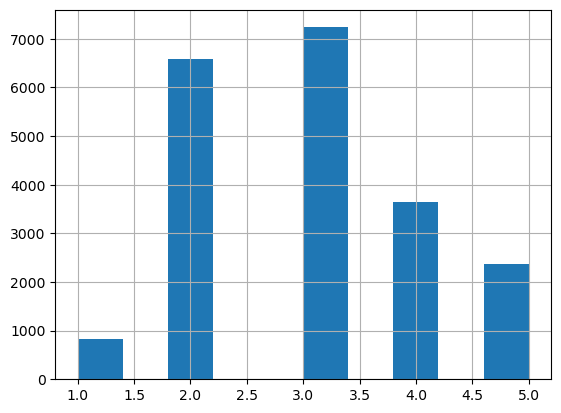

In [7]:
housing['income_cat'].hist()

In [8]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)


train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)


In [9]:
train_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
14196    -117.03     32.71                33.0       3126.0           627.0   
8267     -118.16     33.77                49.0       3382.0           787.0   
17445    -120.48     34.66                 4.0       1897.0           331.0   
14265    -117.11     32.69                36.0       1421.0           367.0   
2271     -119.80     36.78                43.0       2382.0           431.0   

       population  households  median_income  median_house_value  \
14196      2300.0       623.0         3.2596            103000.0   
8267       1314.0       756.0         3.8125            382100.0   
17445       915.0       336.0         4.1563            172600.0   
14265      1418.0       355.0         1.9425             93400.0   
2271        874.0       380.0         3.5542             96500.0   

      ocean_proximity income_cat  
14196      NEAR OCEAN          3  
8267       NEAR OCEAN          3  
17445      NEAR OCEAN          3  
14265      NEAR OCEAN          2  
2271           INLAND          3

In [10]:
compare_props = pd.DataFrame(
    {
        "Overall": income_cat_proportions(housing),
        "Stratified": income_cat_proportions(strat_test_set),
        "Random": income_cat_proportions(test_set),
    }
).sort_index()
compare_props["Rand. %error"] = (
    100 * compare_props["Random"] / compare_props["Overall"] - 100
)
compare_props["Strat. %error"] = (
    100 * compare_props["Stratified"] / compare_props["Overall"] - 100
)

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

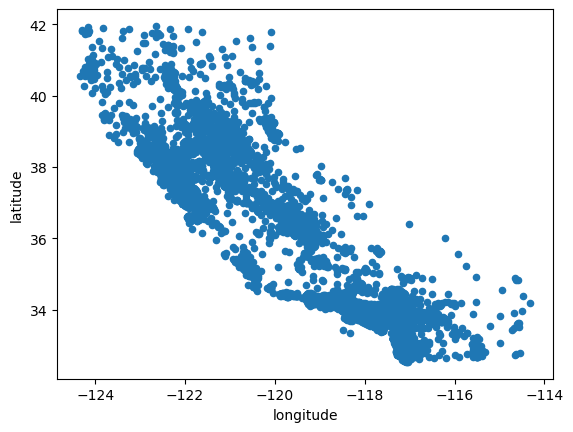

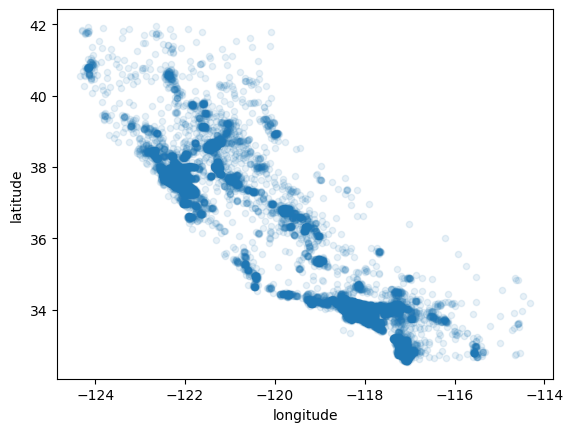

In [11]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude")
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

In [12]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = (
    housing["total_bedrooms"] / housing["total_rooms"]
)
housing["population_per_household"] = (
    housing["population"] / housing["households"]
)

housing = strat_train_set.drop(
    "median_house_value", axis=1
)  # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

imputer = SimpleImputer(strategy="median")

housing_num = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_num)
X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)
housing_tr["rooms_per_household"] = (
    housing_tr["total_rooms"] / housing_tr["households"]
)
housing_tr["bedrooms_per_room"] = (
    housing_tr["total_bedrooms"] / housing_tr["total_rooms"]
)
housing_tr["population_per_household"] = (
    housing_tr["population"] / housing_tr["households"]
)

housing_cat = housing[["ocean_proximity"]]
housing_prepared = housing_tr.join(
    pd.get_dummies(housing_cat, drop_first=True)
)

/tmp/ipykernel_33414/1493812619.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


In [13]:
housing_prepared.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   

       population  households  median_income  rooms_per_household  \
12655      2237.0       706.0         2.1736             5.485836   
15502      2015.0       768.0         6.3373             6.927083   
2908        667.0       300.0         2.8750             5.393333   
14053       898.0       483.0         2.2264             3.886128   
20496      1837.0       580.0         4.4964             6.096552   

       bedrooms_per_room  population_per_household  ocean_proximity_INLAND  \
12655           0.205784                  3.168555                       1   
15502           0.160714                  2.623698                       0   
2908            0.191595                  2.223333                       1   
14053           0.276505                  1.859213                       0   
20496           0.182692                  3.167241                       0   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
12655                       0                         0   
15502                       0                         0   
2908                        0                         0   
14053                       0                         0   
20496                       0                         0   

       ocean_proximity_NEAR OCEAN  
12655                           0  
15502                           1  
2908                            0  
14053                           1  
20496                           0

### Exercise 2

Use Randomized Search CV for the SVR algorithm

In [13]:
from scipy.stats import expon, reciprocal

param_distribs = {
    'kernel': ['linear', 'rbf'],
    'C': reciprocal(20,20000),
    'gamma': expon(scale=1.0)
}

In [15]:
svm_regressor = SVR()
rand_search = RandomizedSearchCV(svm_regressor,
                                 param_distribs,
                                 n_iter=8,
                                 cv=2,
                                 scoring='neg_mean_squared_error',
                                 verbose=2,
                                 n_jobs=-1,
                                 random_state=42)

rand_search.fit(housing_prepared, housing_labels)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END C=58.750769152656574, gamma=0.059838768608680676, kernel=rbf; total time=  19.2s
[CV] END C=4366.193678104918, gamma=0.9084469696321253, kernel=rbf; total time=  20.1s
[CV] END C=4366.193678104918, gamma=0.9084469696321253, kernel=rbf; total time=  20.2s
[CV] END C=58.750769152656574, gamma=0.059838768608680676, kernel=rbf; total time=  21.4s
[CV] END C=23.055974256464793, gamma=3.503557475158312, kernel=rbf; total time=  18.8s
[CV] END C=23.055974256464793, gamma=3.503557475158312, kernel=rbf; total time=  19.8s
[CV] END C=13082.421055385465, gamma=0.0007790692366582295, kernel=rbf; total time=  20.3s
[CV] END C=13082.421055385465, gamma=0.0007790692366582295, kernel=rbf; total time=  20.8s
[CV] END C=70.99757664393003, gamma=0.3627537294604771, kernel=rbf; total time=  20.7s
[CV] END C=70.99757664393003, gamma=0.3627537294604771, kernel=rbf; total time=  20.8s
[CV] END C=21.000465008462697, gamma=0.02333252359832338

RandomizedSearchCV(cv=2, estimator=SVR(), n_iter=8, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f434f5da340>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f434f613fd0>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [16]:
negative_mse_rnd = rand_search.best_score_
rmse_rnd = np.sqrt(-negative_mse_rnd)
rmse_rnd

70874.98448995409

In [17]:
rand_search.best_params_

{'C': 265.8583788632432, 'gamma': 3.010121430917521, 'kernel': 'linear'}

Exercise 3

Try adding a transformer in the preparation pipeline to select only most imoportant features

In [17]:
# Custom Transformer

from sklearn.base import BaseEstimator, TransformerMixin

col_names = "total_rooms", "total_bedrooms", "population", "households"

rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names
]

class addAttributes(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[rooms_per_household,
                     population_per_household,
                     bedrooms_per_room] 
